In [23]:
import crudeForecast
import matplotlib.pyplot as plt
import warnings;
warnings.filterwarnings('ignore');
plt.rcParams["figure.figsize"] = (20,10)

Reading data from file and storing as a dictionary of pandas.DataFrames for future analysis.

In [2]:
data = crudeForecast.read_data('ds-challange-circuitdata.csv')

Collecting models in a dictionary by id (keys for data dictionary). The models are based on a random quantile forest and use the calendar week, day of the week, and minutes since midnight as independent variables to train the model. 

Inputs into the model are:
    data               pandas.DataFrame
    lag_len            default is 48 (15 minute time) invervals and is used to apply 
                       adjustments forecast based on current data
    fcst_len           default is 48 (15 minute time) intervals and is the length of the                          forecast
    test_len           default is 48 (15 minute time) intervals and is used to test model
                       accuracy (rms error)
    min_samples_split  default is 2, minimum number of samples needed to create a new
                       branch
    n_estimators       default is 1000, number of estimators used 
    j_jobs             default is 4, number of threads used



In [6]:
model_dict = {}
for key in data.keys():
    model_dict.update({key: crudeForecast.CompleteForecast(data[key], n_estimators=100, n_jobs=8)})

It is possible to train and predict individual components (e.g. model.train('power')) or you can train all components with model.train_all()

Note: This will take some time, especially if n_estimators is large. Go have a coffee, or tea, possibly lunch, or even start before leaving for the day. Training is meant to be done on a weekly basis or once per day as it is extremely taxing on computers. Reducing n_estimators will reduce computational times, but will also reduce accuracy. Another important point is that this model has only been crudely optimised (hence the title "crudeForecast"), forms of regularization can be implemented and compared using the test function(s), but there is not enough time to run for this assignment.

In [7]:
for key in data.keys():
    model_dict[key].train_all()

In [17]:
rms_err_dict = {}
for key in data.keys():
    print(key)
    rms_err_dict.update({key: model_dict[key].test_all()})
    print('')

69
power
 RMS error: 0.18058939323958934
consumption
 RMS error: 0.18272611990489293
capacity
 RMS error: 0.18016404995449023
expected_capacity
 RMS error: 0.1749616842648451
availibility
 RMS error: 0.17173060405172444
response_from_gen
 RMS error: nan
response_from_dem
 RMS error: nan

75
power
 RMS error: 0.20278850697977707
consumption
 RMS error: 0.20124518488236137
capacity
 RMS error: 0.08678089709856852
expected_capacity
 RMS error: 0.08725159025582986
availibility
 RMS error: 0.08518964677307513
response_from_gen
 RMS error: nan
response_from_dem
 RMS error: nan

97
power
 RMS error: 0.35128850792466737
consumption
 RMS error: 0.34860218724387465
capacity
 RMS error: 0.0726795430492644
expected_capacity
 RMS error: 0.07286343909298815
availibility
 RMS error: 0.07231621708046924
response_from_gen
 RMS error: nan
response_from_dem
 RMS error: nan



Above are the resulting root mean squared errors for the various fitted parameters for a 12 hour window. By increasing the number of estimators and introducing regualarization parameters, this can be reduced, though at the expense of computation time.

Now it is possible to generate forecasts for each of the sites for all of the relevant components (end points). As with the models, the results will be stored in a dictionary, but this dictionary will contain pandas.DataFrames with forecasts for 12 hours starting at the end of the supplied data for each of the relevant end points (power, consumption, capacity, expected capacity, etc.)

In [10]:
fcast_dict = {}
for key in data.keys():
    fcast_dict.update({key: model_dict[key].predict_all(data[key])})

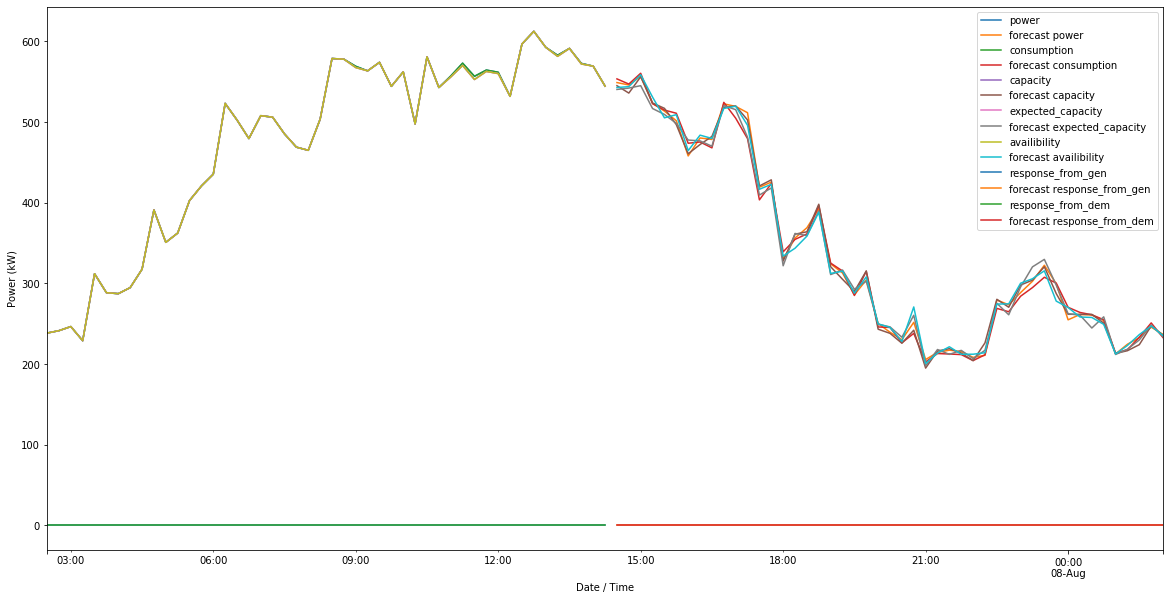

In [25]:
site_to_plot = 69 # set site number you wish to see plotted
ts = data[site_to_plot].index[-48]
for key in fcast_dict[site_to_plot].keys():
    data[site_to_plot].loc[ts:, key].plot(label=key)
    fcast_dict[site_to_plot][key].plot(label='forecast {}'.format(key))
plt.legend()
plt.xlabel('Date / Time')
plt.ylabel('Power (kW)')
#plt.figure(figsize=(40,20), dpi=80)
plt.show()